# Models

In [3]:
from sklearn import datasets
from sklearn.ensemble._weighted_boosting import AdaBoostClassifier
import shap

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

ADABoost_model = AdaBoostClassifier()
ADABoost_model.fit(X, y)

shap_values = shap.TreeExplainer(ADABoost_model)
# .shap_values(X)
# shap.summary_plot(shap_values, X, plot_type="bar")

ModuleNotFoundError: No module named 'sklearn.ensemble._weighted_boosting'

In [128]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import numpy
import math
import shap 
import tensorflow as tf
import matplotlib.pyplot as plt
import lightgbm as ltb

from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

numpy.set_printoptions(threshold=sys.maxsize)


In [129]:
# load pre porcessed data
df = pd.read_csv('../../../prepross_data/data_dka.csv')


#### Filterout the paper described patient set

In [130]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [131]:
# remove all unknown data

# df.drop(df[df.DKAPast12mos == '3.Unknown'].index, inplace=True)
df.drop(df[df.DKAPast12mos == 2].index, inplace=True)

In [132]:
df1 = df.loc[(df['DKAPast12mos'] ==0 ) & (df['Pt_HospDKASinceDiag'] == 0)]
len(df1)

23

### for DKA events prediction pre processing


In [133]:
y_label = 'DKAPast12mos' 

# df[y_label] = df[y_label].replace({
#     'False': False,
#     'True': True
# })
# df[y_label].unique().tolist()


In [134]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition


# def fill_y_label(row):
#     if(pd.isna(row[y_label])):
#         if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
#             row[y_label] = True
#         else:
#             row[y_label] = False
#     return row


# df = df.apply(lambda row: fill_y_label(row), axis=1)

# df[y_label] = df[y_label].astype(int)

def fill_y_label(row):

    if(math.isnan(row['DKAPast12mos'])):
        if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [135]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

df['Pt_SmokeAmt'].mode()

0    1.0
dtype: float64

In [136]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# DKADiag {'1.Yes': 0, '2.Probably Yes': 1, '3.No': 2, '4.Unknown': 3}
# df['DKADiag'] = df['DKADiag'].replace({1.0: 0.0, 2.0:1.0, 3.0:1.0})
    
get_possible_vals_with_nan(df, 'DKADiag')


[2.0, 3.0, 0.0, 1.0]

In [137]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [138]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']


df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CancPancr,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration
0,3963.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [139]:
# gender specific data
# number of F and M
# check gender distribution of selected dataset  Gender {'F': 0, 'M': 1, 'T': 2}

gender_groupby = df.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)

   Gender  total
0     0.0   3353
1     1.0   2816
2     2.0      2


In [140]:
# patient count with both SH and DKA in past 12 months

both_sh_dka_ever = df.loc[(df['DKADiag']==0.0) & (df['Pt_SevHypoEver'] == 0.0) ].shape[0]
both_12_mon =  df.loc[(df['DKAPast12mos']==0.0) & (df['SHSeizComaPast12mos'] == 0.0) ].shape[0]

print('patients with sh and dka both ever: ', both_sh_dka_ever)
print('patients with sh and dka both within 12 months: ', both_12_mon)

patients with sh and dka both ever:  142
patients with sh and dka both within 12 months:  12


# Divide Dataset

In [141]:
df = df[['AgeAtConsent','diagDuration','HbA1c','Gender','Pt_RaceEth',
         'Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel','bmi',
         'Pt_NumBolusDay',
         'Pt_InsulinRecMethod',
#          'InsulinDeliv', 
         'Pt_SmokeAmt',
             'relative_T1D',y_label
            ]]

In [142]:
# df=df.drop('PtID', axis = 1)

In [143]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


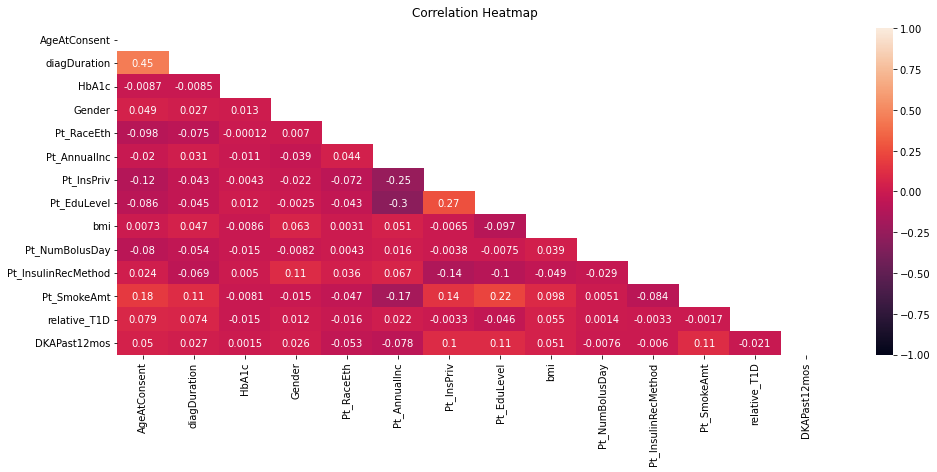

In [144]:

# df.drop(['Lipoatrophy',
#  'AgeAtConsent',
#  'InsCarbRatDinn',
#  'InsNovolog',
#  'CGMGlucPctBelow60'], inplace=True, axis=1)
# df.head(10)


plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')


In [145]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [146]:
Y.unique()

array([1., 0.])

# Feature Selection

In [147]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [148]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [149]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 150 4478]
Test -  [0. 1.] [  50 1493]


# Imputations

<AxesSubplot:>

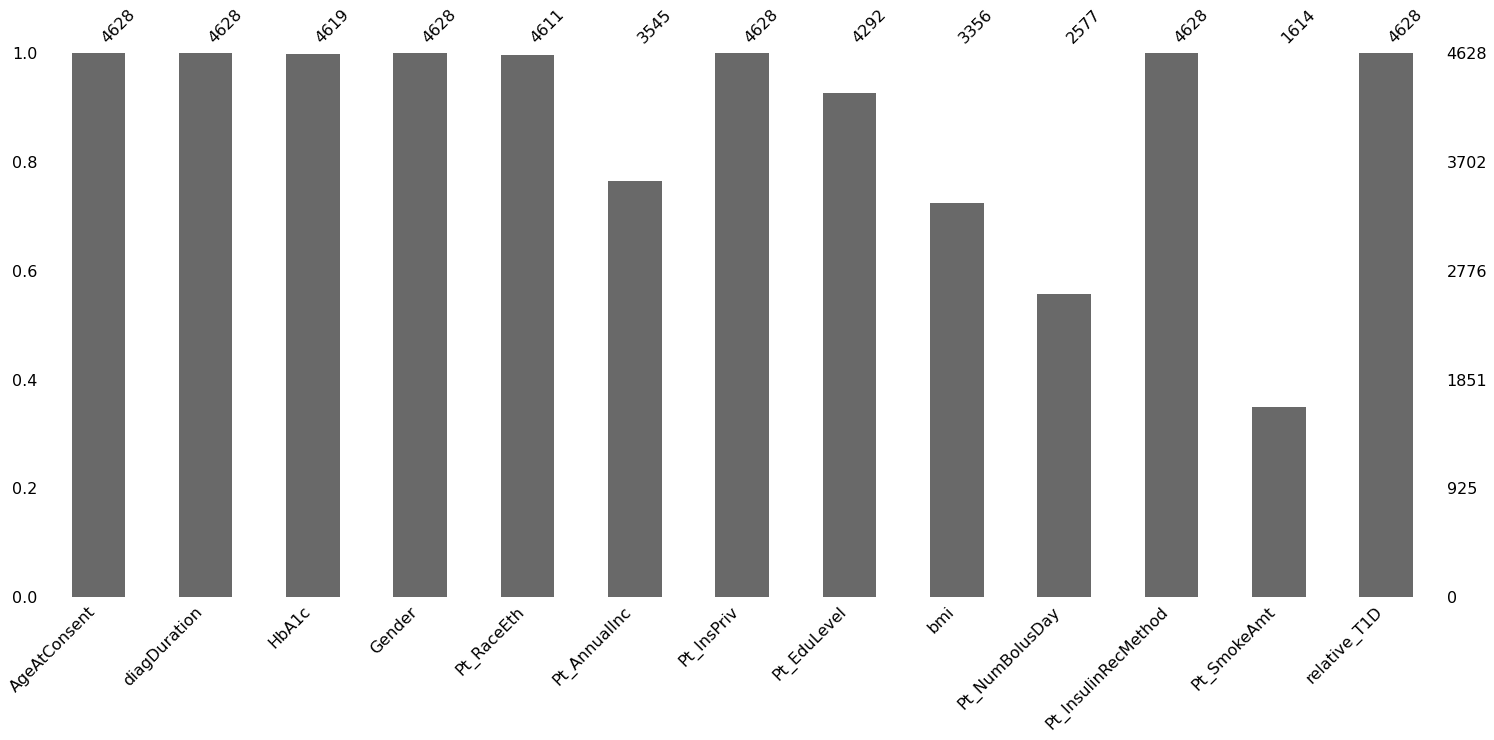

In [150]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [151]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [82]:
# use only for XGB classifier with missing values

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [83]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values

def cross_val_with_missing_val(model):


    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)
        i += 1
        
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

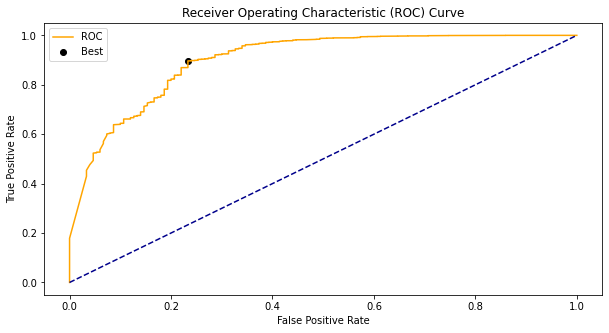

accuracy score:  89.23941227312014
              precision    recall  f1-score   support

         0.0       0.20      0.77      0.32       150
         1.0       0.99      0.90      0.94      4478

    accuracy                           0.89      4628
   macro avg       0.60      0.83      0.63      4628
weighted avg       0.97      0.89      0.92      4628



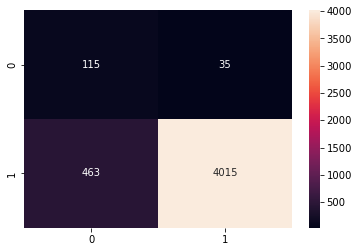

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9754441794076124


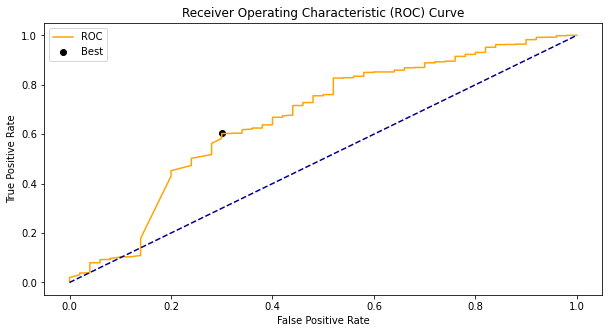

accuracy score:  60.59624108878807
              precision    recall  f1-score   support

         0.0       0.06      0.70      0.10        50
         1.0       0.98      0.60      0.75      1493

    accuracy                           0.61      1543
   macro avg       0.52      0.65      0.43      1543
weighted avg       0.95      0.61      0.73      1543



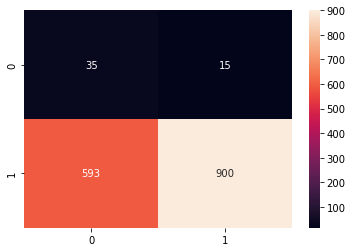

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6653


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.7        0.60281313]
average accuracy:  0.6514065639651707
f1 0.6059624108878807


In [84]:
# xgboost - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 50,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test, average='micro'))  

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

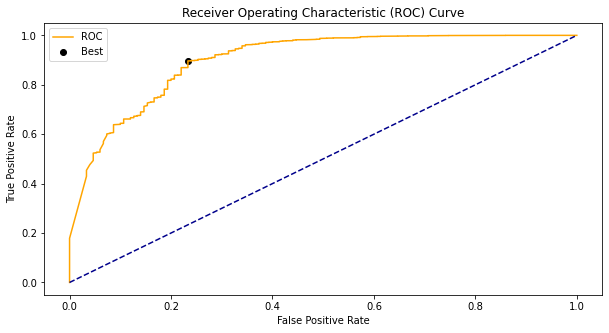

accuracy score:  89.23941227312014
              precision    recall  f1-score   support

         0.0       0.20      0.77      0.32       150
         1.0       0.99      0.90      0.94      4478

    accuracy                           0.89      4628
   macro avg       0.60      0.83      0.63      4628
weighted avg       0.97      0.89      0.92      4628



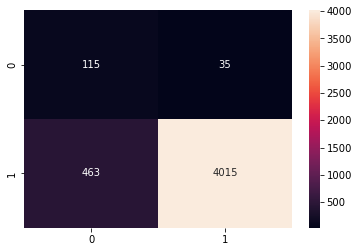

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9754441794076124


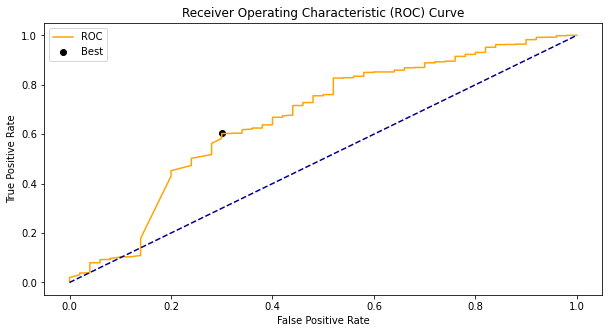

accuracy score:  60.59624108878807
              precision    recall  f1-score   support

         0.0       0.06      0.70      0.10        50
         1.0       0.98      0.60      0.75      1493

    accuracy                           0.61      1543
   macro avg       0.52      0.65      0.43      1543
weighted avg       0.95      0.61      0.73      1543



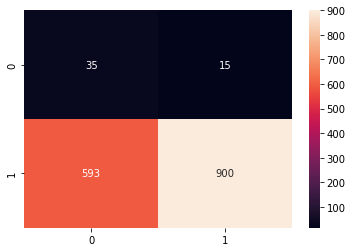

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6653


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.7        0.60281313]
average accuracy:  0.6514065639651707
f1 0.6059624108878807


In [85]:
# xgboost - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 50,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

# print('f1', metrics.f1_score(, Y_test))
print('f1', metrics.f1_score(xgb_pred, Y_test, average='micro'))  

In [29]:
# feature importance graph of XGB
# feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
# feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 3 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 7 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 8 on the test set: 0.9632829373650108, doublecheck: 0.9632829373650108
Accuracy for the fold no. 9 on the test set: 0.9653679653679653, doublecheck: 0.9653679653679653
Accuracy for the fold no. 10 on the test set: 0.9653679653679653, doublecheck: 0.9653679653679653
Cross validation mean accurac

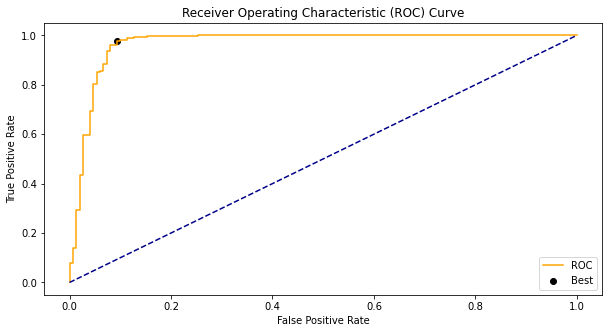

accuracy score:  97.32065687121867
              precision    recall  f1-score   support

         0.0       0.55      0.91      0.69       150
         1.0       1.00      0.98      0.99      4478

    accuracy                           0.97      4628
   macro avg       0.77      0.94      0.84      4628
weighted avg       0.98      0.97      0.98      4628



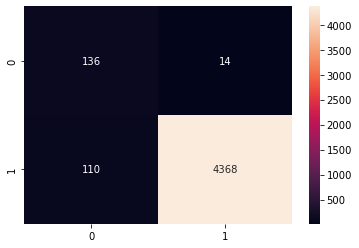

Accuracy of XGB on training set: 0.98


 ===========   Test Dataset    =============
Threshold value is: 2.562838


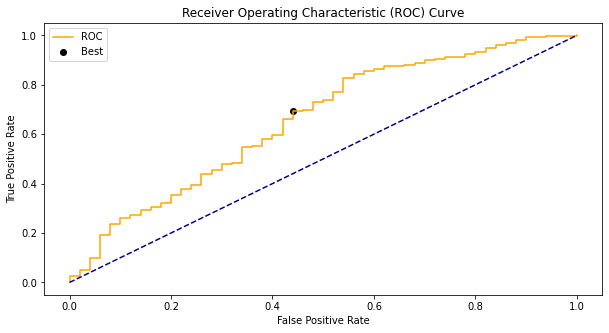

accuracy score:  69.02138690861958
              precision    recall  f1-score   support

         0.0       0.06      0.56      0.10        50
         1.0       0.98      0.69      0.81      1493

    accuracy                           0.69      1543
   macro avg       0.52      0.63      0.46      1543
weighted avg       0.95      0.69      0.79      1543



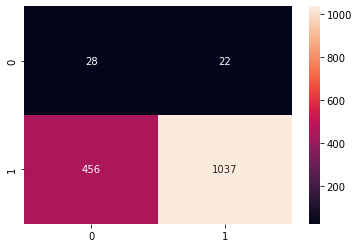

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6571


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.56       0.69457468]
average accuracy:  0.6272873409243135
f1 0.8126959247648903


In [88]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 5, #values between(3-10)
        max_delta_step = 10,
# #         scale_pos_weight = 0.4,
# #         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test))


<AxesSubplot:>

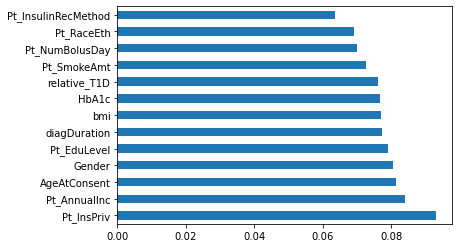

In [89]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(20).plot(kind='barh')

### LGBM Classifier with missing values

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

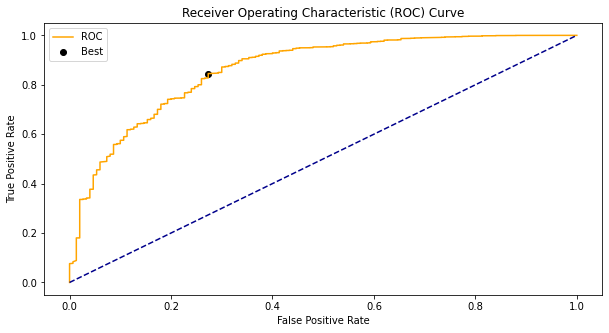

accuracy score:  84.16162489196198
              precision    recall  f1-score   support

         0.0       0.14      0.73      0.23       150
         1.0       0.99      0.85      0.91      4478

    accuracy                           0.84      4628
   macro avg       0.56      0.79      0.57      4628
weighted avg       0.96      0.84      0.89      4628



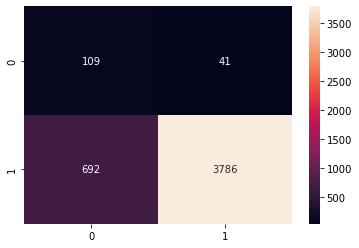

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9734996363677036


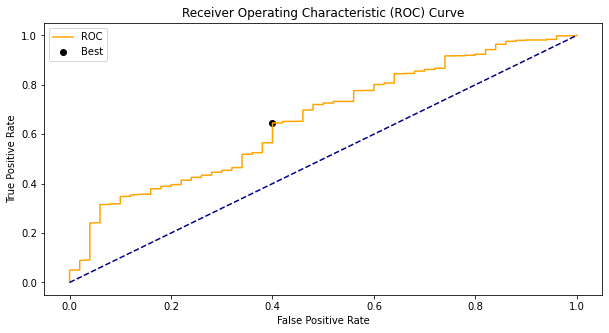

accuracy score:  64.4199611147116
              precision    recall  f1-score   support

         0.0       0.05      0.60      0.10        50
         1.0       0.98      0.65      0.78      1493

    accuracy                           0.64      1543
   macro avg       0.52      0.62      0.44      1543
weighted avg       0.95      0.64      0.76      1543



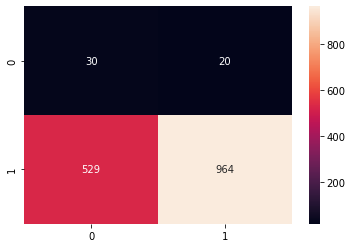

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6593


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.6        0.64567984]
average accuracy:  0.6228399196249162
f1 0.7783609204683083


In [90]:

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True, 
                         learning_rate = 0.01, 
#                          scale_pos_weight=7,
                         max_depth =4, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

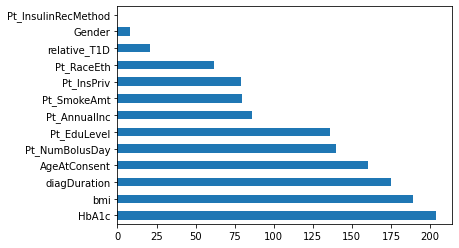

In [91]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(25).plot(kind='barh')

In [35]:
# if is_male:
    
#     X_train.update(X_train[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))

#     X_test.update(X_test[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))
    
# else:
#     X_train.update(X_train[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))

#     X_test.update(X_test[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))
    

In [152]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [153]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [154]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
# select[0] = pd.DataFrame(scaler.fit_transform(X_train))
# select[1] = Y_train
# select[2] = pd.DataFrame(scaler.transform(X_test))


select[0] = pd.DataFrame(X_train)
select[1] = Y_train
select[2] = pd.DataFrame(X_test)



## Feature Selection

In [155]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [156]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
    
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [157]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[06:47:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [158]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['AgeAtConsent', 'diagDuration', 'HbA1c', 'Gender', 'Pt_RaceEth',
       'Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel', 'bmi', 'Pt_NumBolusDay',
       'Pt_InsulinRecMethod', 'Pt_SmokeAmt', 'relative_T1D'],
      dtype='object')
(6171, 13)


In [159]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [160]:

# if('NumDKAOccur' in X_train.columns):
#     X_train = X_train.drop(['NumDKAOccur'], axis=1)
#     X_test = X_test.drop([ 'NumDKAOccur'], axis=1)
    
# if('Pt_NumHospDKA' in X_train.columns):
#     X_train = X_train.drop(['Pt_NumHospDKA'], axis=1)
#     X_test = X_test.drop([ 'Pt_NumHospDKA'], axis=1)
    
# if('Pt_HospDKASinceDiag' in X_train.columns):
#     X_train = X_train.drop(['Pt_HospDKASinceDiag'], axis=1)
#     X_test = X_test.drop([ 'Pt_HospDKASinceDiag'], axis=1)


### Common functions

In [161]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
            
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



In [162]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
#     optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    return optimal_threshold

In [163]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    print('f1', metrics.f1_score(pred, Y_test, average='micro'))  

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

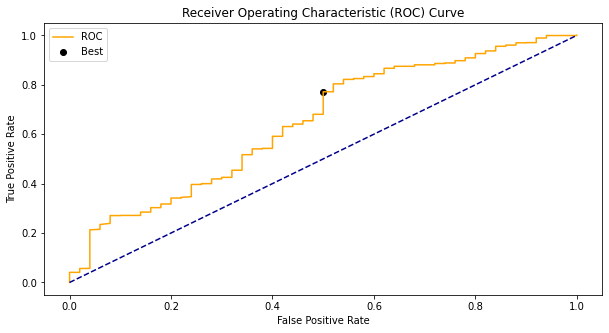

0.9090055084114932
Threshold value is: 0.9697479668549397


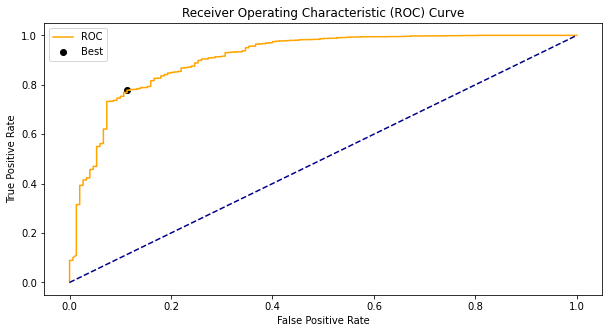


 
 =====================   Train Dataset    ======================
78.15471045808124
              precision    recall  f1-score   support

         0.0       0.12      0.89      0.21       150
         1.0       1.00      0.78      0.87      4478

    accuracy                           0.78      4628
   macro avg       0.56      0.83      0.54      4628
weighted avg       0.97      0.78      0.85      4628



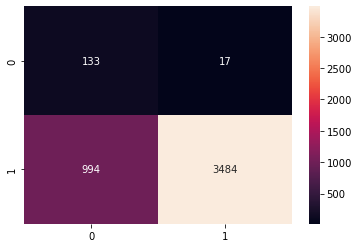

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
76.2799740764744
              precision    recall  f1-score   support

         0.0       0.07      0.50      0.12        50
         1.0       0.98      0.77      0.86      1493

    accuracy                           0.76      1543
   macro avg       0.52      0.64      0.49      1543
weighted avg       0.95      0.76      0.84      1543



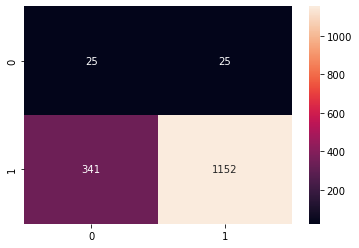

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6483


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.5       0.7716008]
average accuracy:  0.6358004018754186
f1 0.762799740764744
f1 0.8629213483146069


In [164]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model = ltb.LGBMClassifier(use_missing = False, 
                         learning_rate = 0.01, 
                         max_depth =6, random_state=0 )
# ltb_model.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model)

# pred=ltb_model.predict(X_test)
# pred_train=ltb_model.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)

print('f1', metrics.f1_score(pred, Y_test))

<AxesSubplot:>

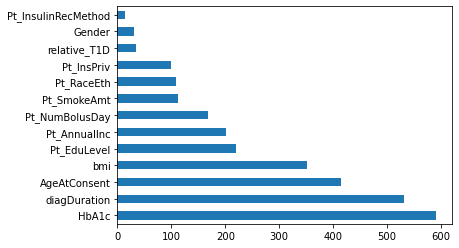

In [165]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [166]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.DKAPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)


    plt.axhline(y=thresh1, color='r')
    plt.axhline(y=thresh2, color = 'g')
    
    plt.axhspan(0.4, thresh1, facecolor='red', alpha=0.05)
    plt.axhspan(thresh1, thresh2, facecolor='yellow', alpha=0.05)
    plt.axhspan(thresh2, 1, facecolor='green', alpha=0.05)


    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()


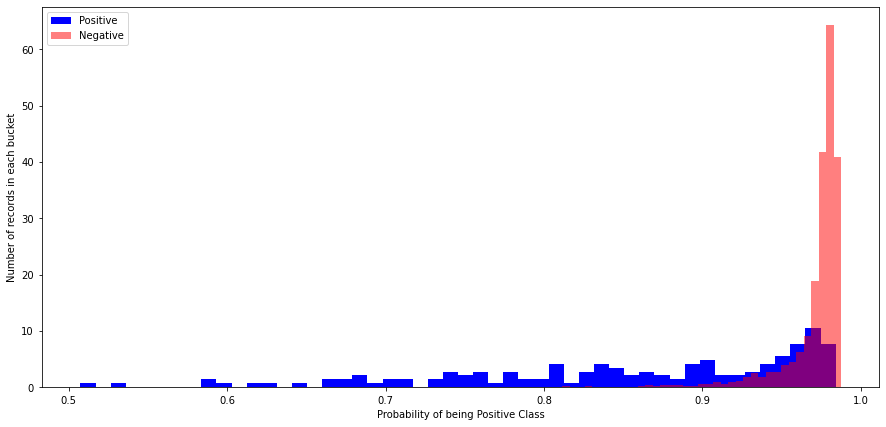

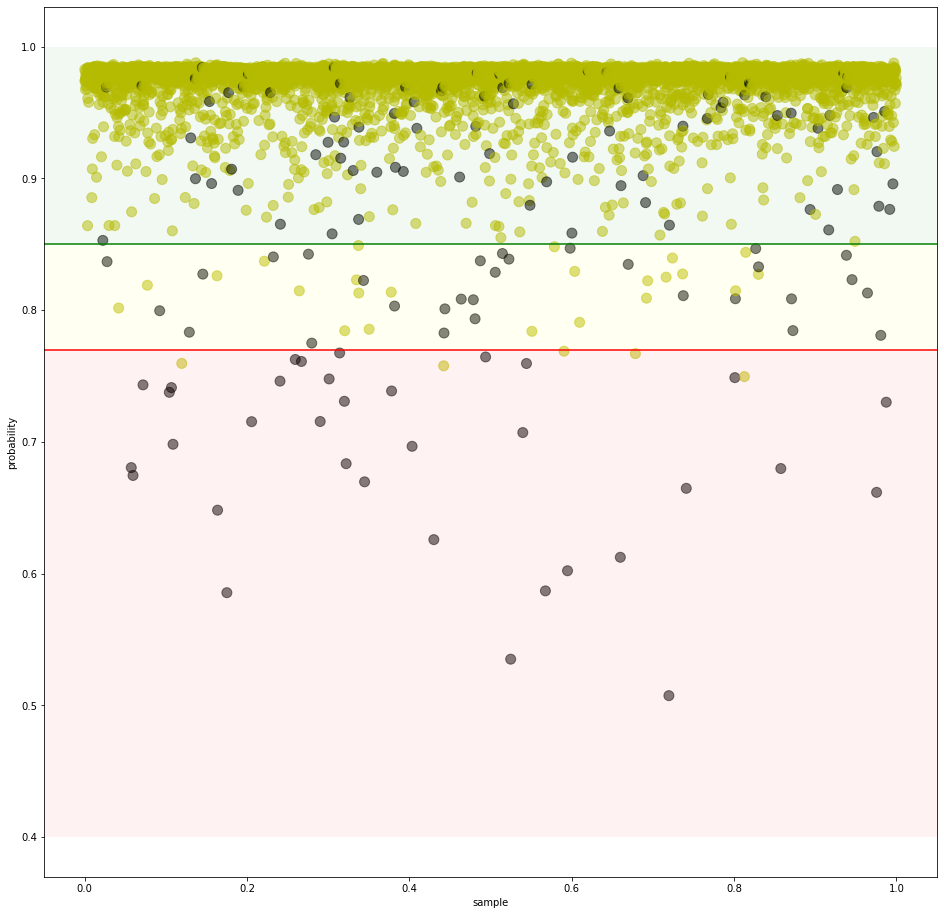

In [167]:
patients_count = X_train.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.8
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(ltb_model, X_train, 8000, 200)
thresh2 = 0.85
draw_boundary(ltb_model, X_train, Y_train, thresh1, thresh2)


In [168]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [169]:

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (ltb_model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
ltb_model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(ltb_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

predictoin [1]
actial 1.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [170]:
# compute SHAP values
explainer = shap.Explainer(ltb_model, X_train)
shap_values = explainer(X_train)

 95%|=================== | 4417/4628 [00:13<00:00]       

Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 3.501502, while the model output was 3.370186. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, show=False)
shap.plots.beeswarm(shap_values[-1:], show=False, color="black")
pl.show()

In [ ]:
pred = ltb_model.predict_proba(X_train)[:,1] 

Y = pd.DataFrame(Y_train)
X_beeswarm = X_train.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y
X_beeswarm['Y'] = Y[y_label].to_list()

In [ ]:
idx = np.where((X_beeswarm['pred']>0.98) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0.7) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative case in positive side
idx3 = np.where((X_beeswarm['pred']<0.6) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(ltb_model, X_beeswarm)
shap_values = explainer(X_beeswarm)



Black = Predict negative , actual positive

Orange = Predict positive , actual positive

Green = Predict positive , actual negative

In [ ]:

shap.plots.beeswarm(shap_values, show=False, plot_size=[15,15], alpha = 1)
shap.plots.beeswarm(shap_values[80:81:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[466:467:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[578:579:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1670:1671:], show=False, color="black", plot_size=[15,15])

shap.plots.beeswarm(shap_values[50:51:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[27:28:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[237:238:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[254:255:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[310:311:], show=False, color="orange", plot_size=[15,15])

shap.plots.beeswarm(shap_values[1304:1305:], show=False, color="green", plot_size=[15,15])

plt.show()


Plot shows information-dense summary of how the top features in a dataset impact the model’s output. 

Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. 

Color is used to display the original value of a feature

In the plot HospitalDKA is the most important feature on average, and hospitalDKA = 1 Yes(red) people are more likely to have DKA.


HospitalDKA categories
No: 0,
Yes: 1,
Don\'t know: 2

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9632829373650108, doublecheck: 0.9632829373650108
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9653679653679653, doublecheck: 0.9653679653679653
Cross validation mean accurac

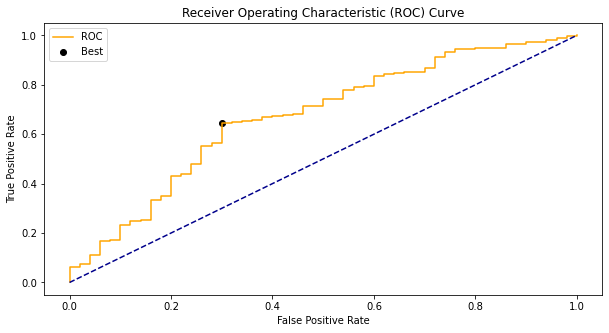

0.8605344647908293
Threshold value is: 0.5082518726065994


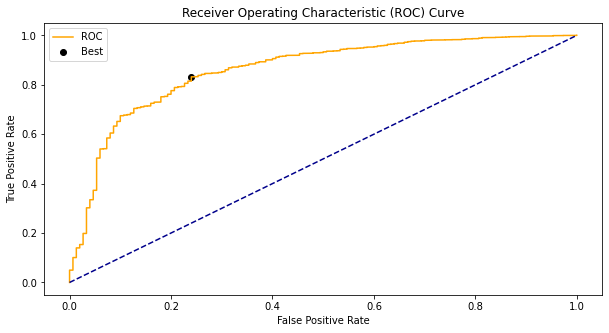


 
 =====================   Train Dataset    ======================
82.97320656871219
              precision    recall  f1-score   support

         0.0       0.13      0.76      0.22       150
         1.0       0.99      0.83      0.90      4478

    accuracy                           0.83      4628
   macro avg       0.56      0.80      0.56      4628
weighted avg       0.96      0.83      0.88      4628



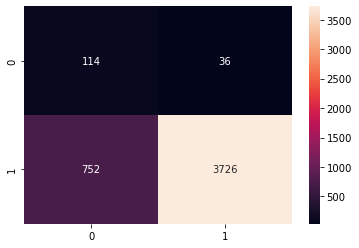

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
64.87362281270252
              precision    recall  f1-score   support

         0.0       0.06      0.70      0.11        50
         1.0       0.98      0.65      0.78      1493

    accuracy                           0.65      1543
   macro avg       0.52      0.67      0.45      1543
weighted avg       0.95      0.65      0.76      1543



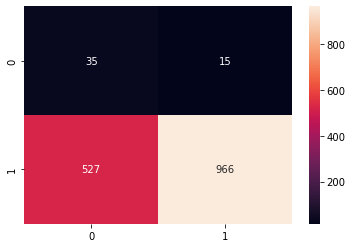

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6716


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.7        0.64701942]
average accuracy:  0.6735097119892832
f1 0.6487362281270252


In [172]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.1,
                              n_estimators=1000,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

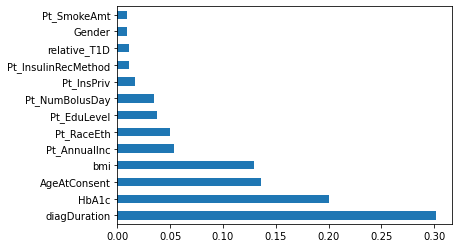

In [173]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [179]:
explainer = shap.KernelExplainer(adaboost, X_train)
shap_values = KernelExplainer(X_train)
shap.plots.bar(shap_values)
plt.savefig('fiDKAbaseline.png')

Provided model function fails when applied to the provided data set.


TypeError: 'AdaBoostClassifier' object is not callable

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 7 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 8 on the test set: 0.958963282937365, doublecheck: 0.958963282937365
Accuracy for the fold no. 9 on the test set: 0.9653679653679653, doublecheck: 0.9653679653679653
Accuracy for the fold no. 10 on the test set: 0.9653679653679653, doublecheck: 0.9653679653679653
Cross validation mean accuracy 

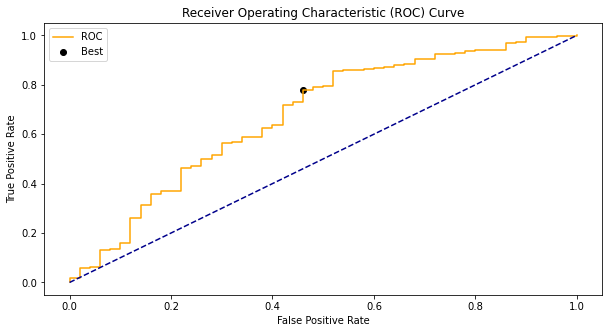

0.9374780407920202
Threshold value is: 2.0228


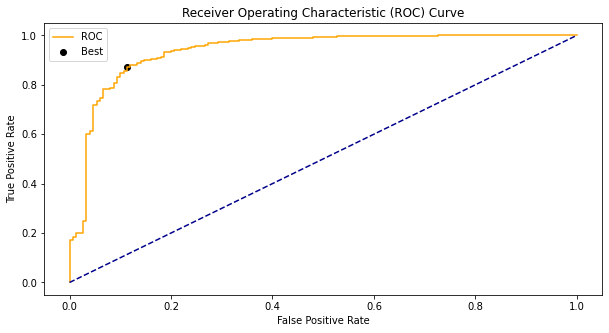


 
 =====================   Train Dataset    ======================
87.31633535004322
              precision    recall  f1-score   support

         0.0       0.19      0.89      0.31       150
         1.0       1.00      0.87      0.93      4478

    accuracy                           0.87      4628
   macro avg       0.59      0.88      0.62      4628
weighted avg       0.97      0.87      0.91      4628



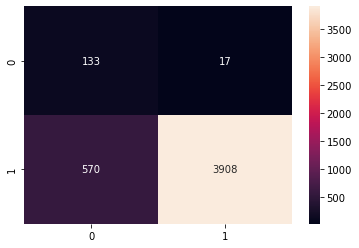

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
77.12248865845756
              precision    recall  f1-score   support

         0.0       0.08      0.54      0.13        50
         1.0       0.98      0.78      0.87      1493

    accuracy                           0.77      1543
   macro avg       0.53      0.66      0.50      1543
weighted avg       0.95      0.77      0.84      1543



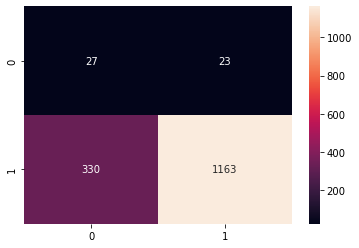

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6757


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.54       0.77896852]
average accuracy:  0.6594842598794374
f1 0.7712248865845756


In [111]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

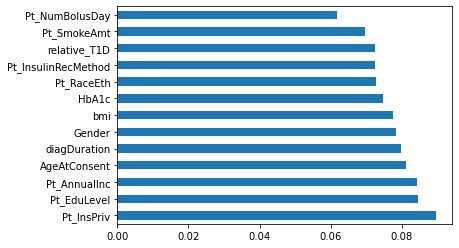

In [112]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

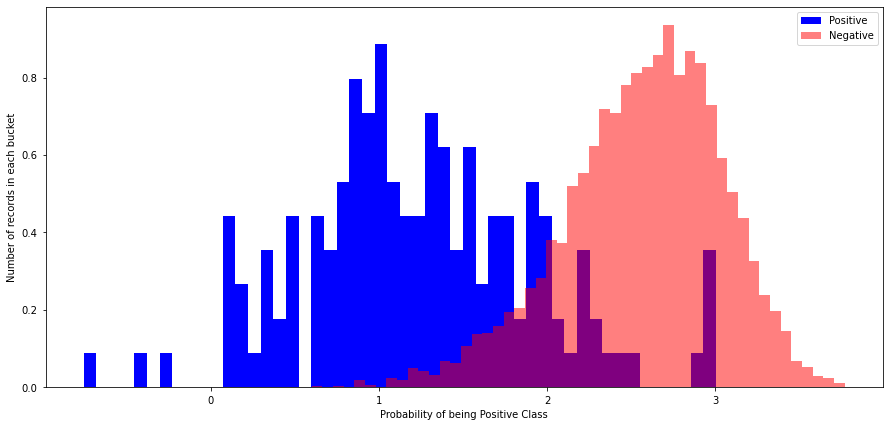

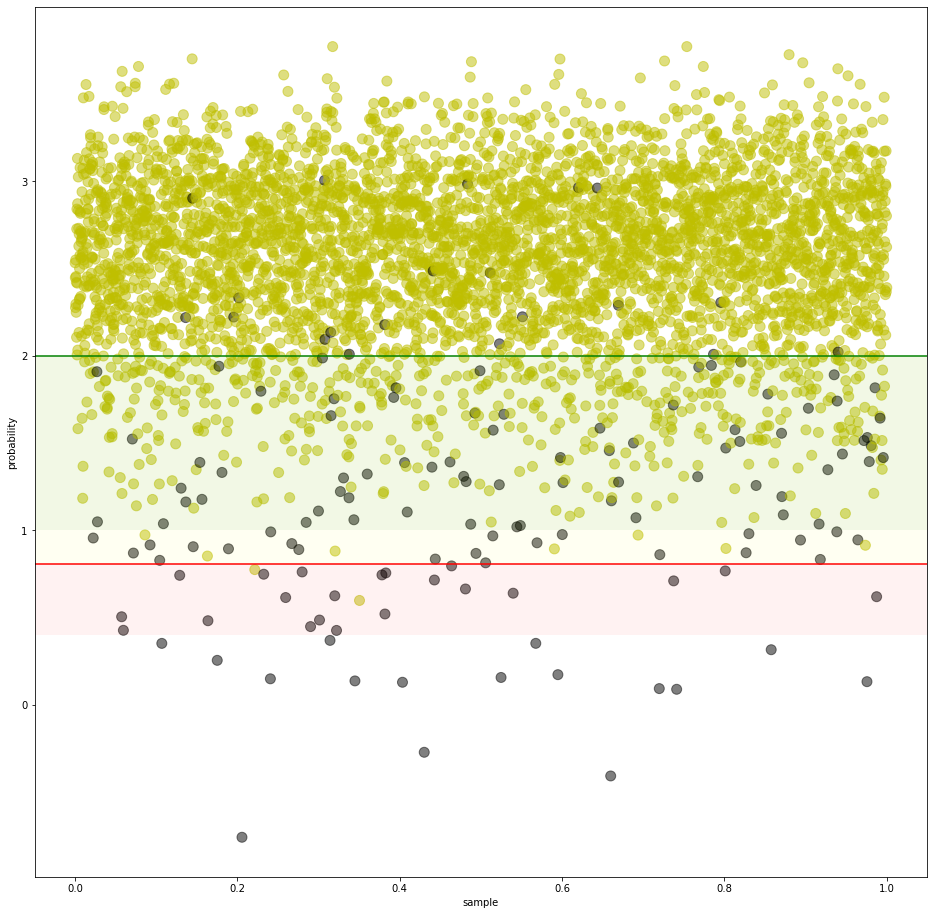

In [113]:
thresh1 = get_optimal_threshold(xgb_impute, X_train, 8000, 200)
thresh2 = 2.0
draw_boundary(xgb_impute, X_train, Y_train, thresh1, thresh2)

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.7732181425485961, doublecheck: 0.7732181425485961
Accuracy for the fold no. 2 on the test set: 0.7494600431965442, doublecheck: 0.7494600431965442
Accuracy for the fold no. 3 on the test set: 0.755939524838013, doublecheck: 0.755939524838013
Accuracy for the fold no. 4 on the test set: 0.8185745140388769, doublecheck: 0.8185745140388769
Accuracy for the fold no. 5 on the test set: 0.8012958963282938, doublecheck: 0.8012958963282938
Accuracy for the fold no. 6 on the test set: 0.7948164146868251, doublecheck: 0.7948164146868251
Accuracy for the fold no. 7 on the test set: 0.775377969762419, doublecheck: 0.775377969762419
Accuracy for the fold no. 8 on the test set: 0.7796976241900648, doublecheck: 0.7796976241900648
Accuracy for the fold no. 9 on the test set: 0.7878787878787878, doublecheck: 0.7878787878787878
Accuracy for the fold no. 10 on the test set: 0.7662337662337663, doublecheck: 0.7662337662337663
Cross validation mean accuracy 0.

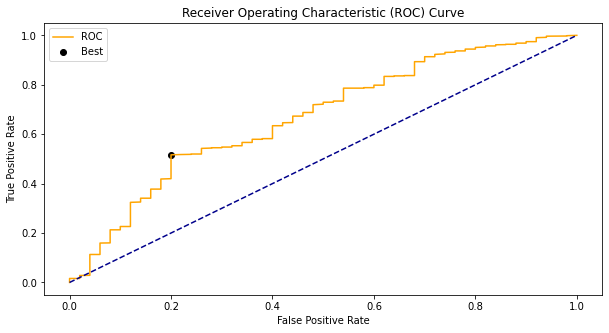

0.7804235521810332
Threshold value is: 0.5220364216602308


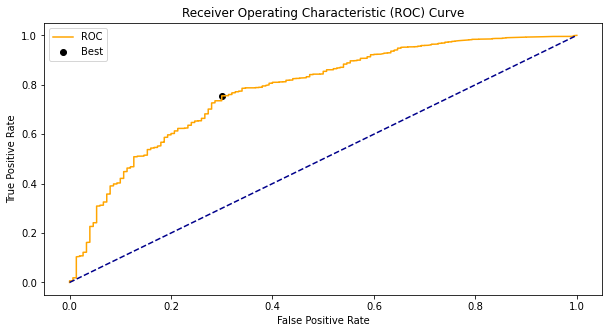


 
 =====================   Train Dataset    ======================
75.3457216940363
              precision    recall  f1-score   support

         0.0       0.09      0.70      0.16       150
         1.0       0.99      0.76      0.86      4478

    accuracy                           0.75      4628
   macro avg       0.54      0.73      0.51      4628
weighted avg       0.96      0.75      0.83      4628



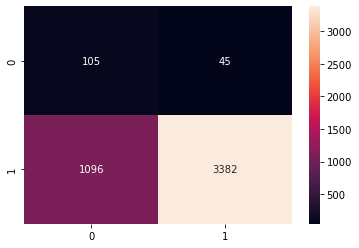

Accuracy of on training set: 0.79


 =====================   Test Dataset    =======================
52.5599481529488
              precision    recall  f1-score   support

         0.0       0.05      0.80      0.10        50
         1.0       0.99      0.52      0.68      1493

    accuracy                           0.53      1543
   macro avg       0.52      0.66      0.39      1543
weighted avg       0.96      0.53      0.66      1543



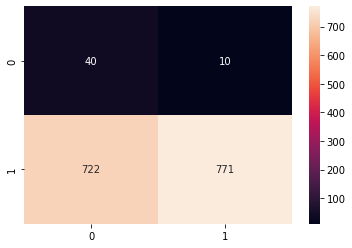

Accuracy of classifier on test set: 0.79


 =======================   Test-ROC    =========================
roc_auc = 0.6698


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8        0.51640991]
average accuracy:  0.6582049564634964
f1 0.525599481529488


In [127]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=4,
                             n_estimators = feature,
                             criterion = 'gini', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
optimal_threshold = optimal_thresh(rf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

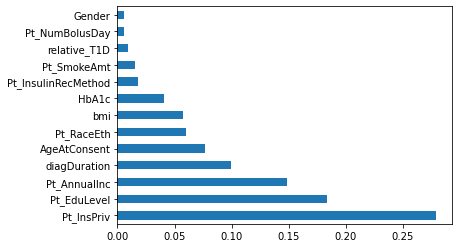

In [115]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.7235421166306696, doublecheck: 0.7235421166306696
Accuracy for the fold no. 2 on the test set: 0.714902807775378, doublecheck: 0.714902807775378


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 3 on the test set: 0.7084233261339092, doublecheck: 0.7084233261339092
Accuracy for the fold no. 4 on the test set: 0.7429805615550756, doublecheck: 0.7429805615550756


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.7300215982721382, doublecheck: 0.7300215982721382
Accuracy for the fold no. 6 on the test set: 0.7019438444924406, doublecheck: 0.7019438444924406


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.4103671706263499, doublecheck: 0.4103671706263499


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 8 on the test set: 0.7105831533477321, doublecheck: 0.7105831533477321
Accuracy for the fold no. 9 on the test set: 0.7532467532467533, doublecheck: 0.7532467532467533
Accuracy for the fold no. 10 on the test set: 0.7424242424242424, doublecheck: 0.7424242424242424
Cross validation mean accuracy 0.6938435574504689
0.6508640321500334
Threshold value is: 0.4907543538129434


The max_iter was reached which means the coef_ did not converge


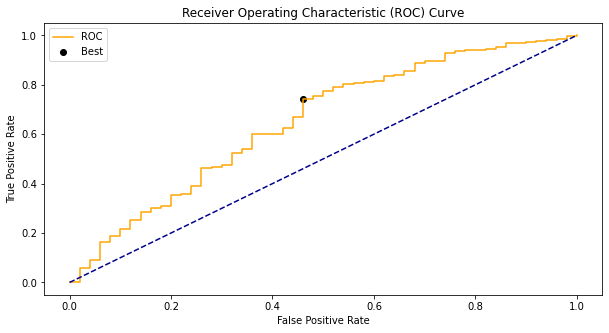

0.7183043025160042
Threshold value is: 0.49222781107175934


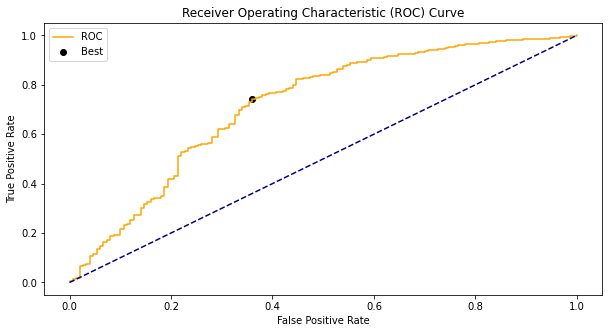


 
 =====================   Train Dataset    ======================
73.98444252376837
              precision    recall  f1-score   support

         0.0       0.08      0.64      0.14       150
         1.0       0.98      0.74      0.85      4478

    accuracy                           0.74      4628
   macro avg       0.53      0.69      0.49      4628
weighted avg       0.95      0.74      0.82      4628



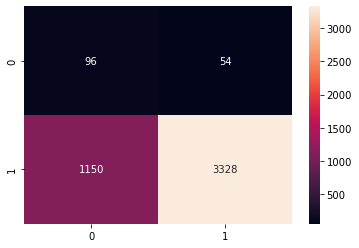

Accuracy of on training set: 0.73


 =====================   Test Dataset    =======================
73.75243033052496
              precision    recall  f1-score   support

         0.0       0.07      0.54      0.12        50
         1.0       0.98      0.74      0.85      1493

    accuracy                           0.74      1543
   macro avg       0.52      0.64      0.48      1543
weighted avg       0.95      0.74      0.82      1543



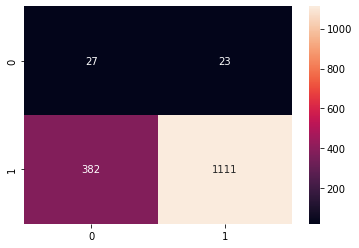

Accuracy of classifier on test set: 0.73


 =======================   Test-ROC    =========================
roc_auc = 0.6509


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.54       0.74413932]
average accuracy:  0.6420696584058943
f1 0.7375243033052497


In [116]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

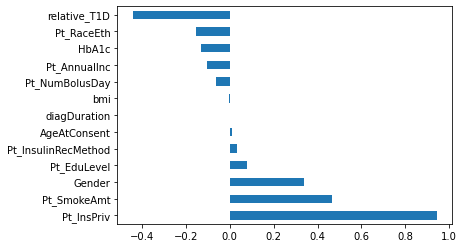

In [117]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 3 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9654427645788337, doublecheck: 0.9654427645788337
Accuracy for the fold no. 6 on the test set: 0.9697624190064795, doublecheck: 0.9697624190064795
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.958963282937365, doublecheck: 0.958963282937365
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accuracy 

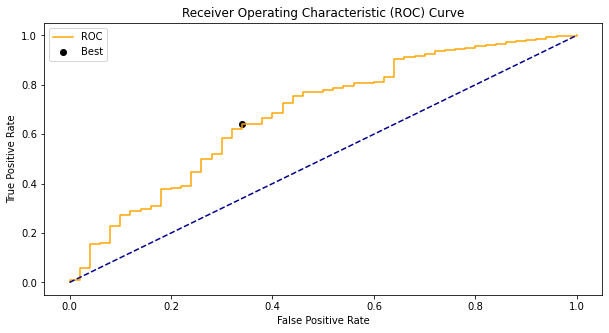

0.7365684085157065
Threshold value is: 0.978685592723678


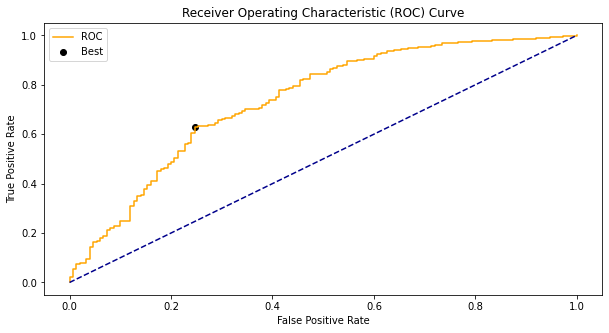


 
 =====================   Train Dataset    ======================
63.353500432152124
              precision    recall  f1-score   support

         0.0       0.06      0.75      0.12       150
         1.0       0.99      0.63      0.77      4478

    accuracy                           0.63      4628
   macro avg       0.53      0.69      0.44      4628
weighted avg       0.96      0.63      0.75      4628



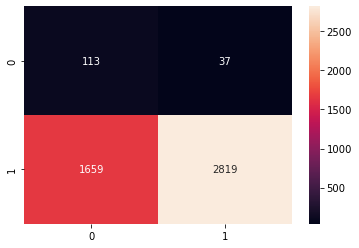

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
64.09591704471809
              precision    recall  f1-score   support

         0.0       0.06      0.66      0.11        50
         1.0       0.98      0.64      0.78      1493

    accuracy                           0.64      1543
   macro avg       0.52      0.65      0.44      1543
weighted avg       0.95      0.64      0.75      1543



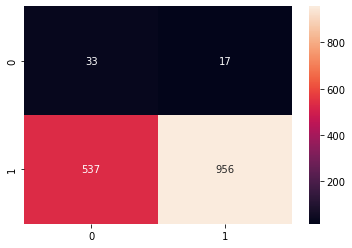

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6821


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.66      0.6403215]
average accuracy:  0.6501607501674481
f1 0.6409591704471809


In [118]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(lda, X_test, Y_test)
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


<AxesSubplot:>

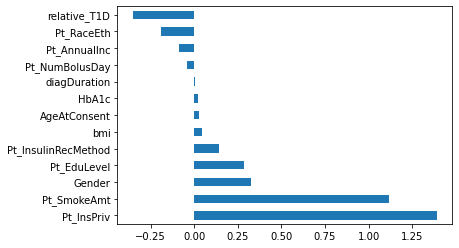

In [119]:
feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')


## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 5 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 6 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 7 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 8 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 9 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Accuracy for the fold no. 10 on the test set: 0.9675324675324676, doublecheck: 0.9675324675324676
Cross validation mean accurac

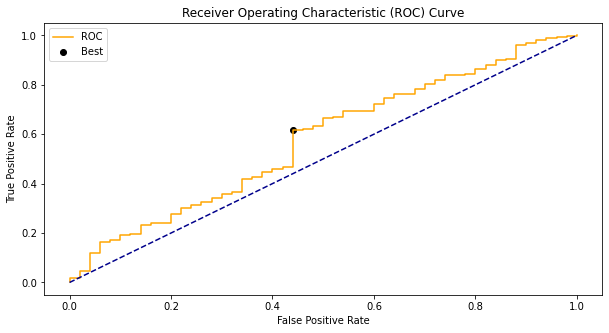

0.6130013398838767
Threshold value is: 0.9637856640969334


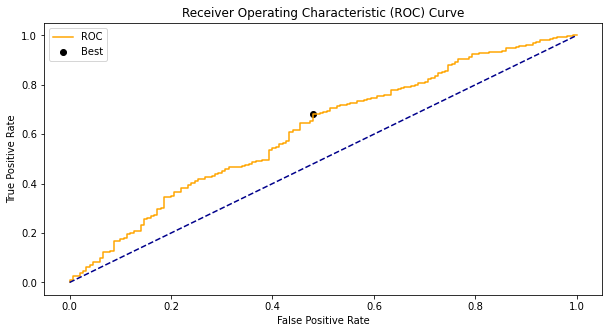


 
 =====================   Train Dataset    ======================
67.73984442523768
              precision    recall  f1-score   support

         0.0       0.05      0.52      0.09       150
         1.0       0.98      0.68      0.80      4478

    accuracy                           0.68      4628
   macro avg       0.51      0.60      0.45      4628
weighted avg       0.95      0.68      0.78      4628



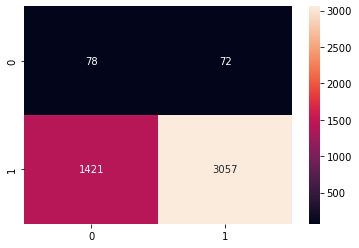

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
61.568373298768634
              precision    recall  f1-score   support

         0.0       0.05      0.56      0.09        50
         1.0       0.98      0.62      0.76      1493

    accuracy                           0.62      1543
   macro avg       0.51      0.59      0.42      1543
weighted avg       0.95      0.62      0.73      1543



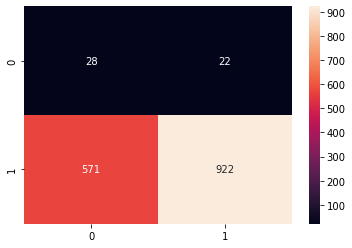

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.5755


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.56       0.61754856]
average accuracy:  0.5887742799732083
f1 0.6156837329876863


In [120]:

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb = cross_val(gnb)

gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


<AxesSubplot:>

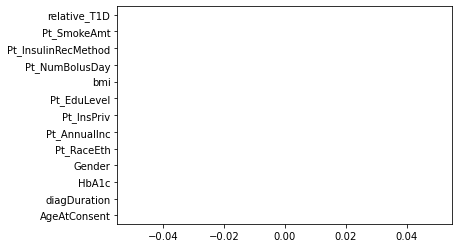

In [121]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [122]:
d = pd.DataFrame(Y_test).head(100)
# s = d[d.DKAPast12mos == 0.0]
# for index, row in d.iterrows():
#     if row.DKAPast12mos == 0.0:
#         print(index)
d      

,DKAPast12mos
1184,1.0
23974,1.0
6461,1.0
22322,1.0
24984,1.0
11883,1.0
14907,1.0
5992,1.0
1530,1.0
271,1.0


## SHAP Values

In [123]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


my_model = RandomForestClassifier(random_state=0).fit(X_train, Y_train)

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = my_model.predict(data_for_prediction_array)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
my_model.predict_proba(data_for_prediction_array)

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)


shap.initjs()

# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

predictoin [1.]
actial 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


NOTE: How do you interpret shap

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from weight being -0.9503. Though the pt_hospDKASinceDiag value has a meaningful effect decreasing the prediction.